In [1]:
import os
import sys
import warnings
import itertools
import math
import logging
import json
import re
import random
from pathlib import Path
from collections import OrderedDict

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Import Mask RCNN
from mrcnn import utils
from mrcnn.visualize import display_images, display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config

from corebreakout import defaults
from corebreakout.datasets import PolygonDataset

%matplotlib inline

Using TensorFlow backend.


## Model Config

In [2]:
config = defaults.DefaultConfig()

In [3]:
defaults.DATASET_DIR

PosixPath('/home/ross/code/python/corebreakout/include/pretrain/data')

## Load Datasets

In [4]:
dataset = PolygonDataset()
dataset.collect_annotated_images(defaults.DATASET_DIR, 'train')
dataset.prepare()

print(dataset)


 PolygonDataset
Image count : 25
Class count : 3
  0. BG                                                
  1. col                                               
  2. tray                                              


In [5]:
test_dataset = PolygonDataset()
test_dataset.collect_annotated_images(defaults.DATASET_DIR, 'test')
test_dataset.prepare()

print(test_dataset)


 PolygonDataset
Image count : 5
Class count : 3
  0. BG                                                
  1. col                                               
  2. tray                                              


# Load pretrained COCO model base

In [6]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=str(defaults.TRAIN_DIR))

model.load_weights(str(defaults.COCO_MODEL_PATH), by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                            "mrcnn_bbox", "mrcnn_mask"])

W0930 12:43:35.154761 139870749820736 deprecation_wrapper.py:119] From /home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0930 12:43:35.180321 139870749820736 deprecation_wrapper.py:119] From /home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0930 12:43:35.201385 139870749820736 deprecation_wrapper.py:119] From /home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0930 12:43:35.219305 139870749820736 deprecation_wrapper.py:119] From /home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1919: The name tf.nn.fused_batch_norm is d

# Three step training run

In [7]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Train network heads
    print('Training network heads')
    model.train(dataset, test_dataset, 
                learning_rate=config.LEARNING_RATE, 
                epochs=15, 
                layers='heads')
    
    # Finetune layers from ResNet stage 4 and up
    print('Tuning stage 4 and up')
    model.train(dataset, test_dataset, 
                learning_rate=config.LEARNING_RATE / 5, 
                epochs=50, 
                layers='4+')
    
    print('Tuning all layers')
    model.train(dataset, test_dataset, 
                learning_rate=config.LEARNING_RATE / 50, 
                epochs=100, 
                layers='all')

Training network heads


W0930 12:50:08.001127 139870749820736 deprecation_wrapper.py:119] From /home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.




Starting at epoch 0. LR=0.001

Checkpoint Path: /home/ross/Dropbox/models/corebreakout/pretrain/cb_default20190930T1243/mask_rcnn_cb_default_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4      

W0930 12:50:11.324080 139870749820736 deprecation_wrapper.py:119] From /home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0930 12:50:11.325505 139870749820736 deprecation_wrapper.py:119] From /home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/15
25/25 [==============================] - 86s 3s/step - loss: 3.0029 - rpn_class_loss: 0.0386 - rpn_bbox_loss: 1.8374 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.6206 - mrcnn_mask_loss: 0.4652 - val_loss: 3.1158 - val_rpn_class_loss: 0.0253 - val_rpn_bbox_loss: 1.7253 - val_mrcnn_class_loss: 0.0194 - val_mrcnn_bbox_loss: 0.7282 - val_mrcnn_mask_loss: 0.6176
Epoch 2/15
25/25 [==============================] - 7s 278ms/step - loss: 1.5698 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.8151 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.2508 - mrcnn_mask_loss: 0.4784 - val_loss: 2.5040 - val_rpn_class_loss: 0.0202 - val_rpn_bbox_loss: 1.5181 - val_mrcnn_class_loss: 0.0185 - val_mrcnn_bbox_loss: 0.4775 - val_mrcnn_mask_loss: 0.4697
Epoch 3/15
25/25 [==============================] - 8s 306ms/step - loss: 1.1518 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.5781 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.1802 - mrcnn_mask_loss: 0.3708 - val_loss: 2.2409 - val_rpn_class_loss: 

Epoch 16/50
25/25 [==============================] - 118s 5s/step - loss: 0.6168 - rpn_class_loss: 4.9072e-04 - rpn_bbox_loss: 0.3541 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0899 - mrcnn_mask_loss: 0.1542 - val_loss: 2.1649 - val_rpn_class_loss: 0.0011 - val_rpn_bbox_loss: 1.3632 - val_mrcnn_class_loss: 0.0197 - val_mrcnn_bbox_loss: 0.4570 - val_mrcnn_mask_loss: 0.3239
Epoch 17/50
25/25 [==============================] - 10s 389ms/step - loss: 0.6011 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.3774 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.0853 - mrcnn_mask_loss: 0.1174 - val_loss: 1.6557 - val_rpn_class_loss: 5.8136e-04 - val_rpn_bbox_loss: 1.0774 - val_mrcnn_class_loss: 0.0203 - val_mrcnn_bbox_loss: 0.3082 - val_mrcnn_mask_loss: 0.2492
Epoch 18/50
25/25 [==============================] - 10s 390ms/step - loss: 0.4617 - rpn_class_loss: 4.3780e-04 - rpn_bbox_loss: 0.2391 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.1022 - mrcnn_mask_loss: 0.1016 - val_loss: 2.0242 - va

Epoch 38/50
25/25 [==============================] - 12s 490ms/step - loss: 0.1711 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0719 - mrcnn_class_loss: 0.0043 - mrcnn_bbox_loss: 0.0160 - mrcnn_mask_loss: 0.0764 - val_loss: 0.8374 - val_rpn_class_loss: 0.0076 - val_rpn_bbox_loss: 0.6080 - val_mrcnn_class_loss: 0.0094 - val_mrcnn_bbox_loss: 0.1088 - val_mrcnn_mask_loss: 0.1036
Epoch 39/50
25/25 [==============================] - 12s 464ms/step - loss: 0.2265 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.1046 - mrcnn_class_loss: 0.0049 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.0756 - val_loss: 0.6424 - val_rpn_class_loss: 6.3915e-04 - val_rpn_bbox_loss: 0.4599 - val_mrcnn_class_loss: 0.0049 - val_mrcnn_bbox_loss: 0.0665 - val_mrcnn_mask_loss: 0.1104
Epoch 40/50
25/25 [==============================] - 12s 493ms/step - loss: 0.2265 - rpn_class_loss: 3.7770e-04 - rpn_bbox_loss: 0.0906 - mrcnn_class_loss: 0.0052 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.0904 - val_loss: 0.6060 - val_

Epoch 51/100
25/25 [==============================] - 123s 5s/step - loss: 0.2042 - rpn_class_loss: 2.9585e-04 - rpn_bbox_loss: 0.1062 - mrcnn_class_loss: 0.0041 - mrcnn_bbox_loss: 0.0140 - mrcnn_mask_loss: 0.0795 - val_loss: 1.4600 - val_rpn_class_loss: 0.0032 - val_rpn_bbox_loss: 0.8939 - val_mrcnn_class_loss: 0.0061 - val_mrcnn_bbox_loss: 0.2899 - val_mrcnn_mask_loss: 0.2669
Epoch 52/100
25/25 [==============================] - 11s 435ms/step - loss: 0.2814 - rpn_class_loss: 7.5137e-04 - rpn_bbox_loss: 0.1945 - mrcnn_class_loss: 0.0043 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0596 - val_loss: 1.6880 - val_rpn_class_loss: 0.0036 - val_rpn_bbox_loss: 1.0359 - val_mrcnn_class_loss: 0.0061 - val_mrcnn_bbox_loss: 0.3446 - val_mrcnn_mask_loss: 0.2978
Epoch 53/100
25/25 [==============================] - 12s 467ms/step - loss: 0.1370 - rpn_class_loss: 1.8390e-04 - rpn_bbox_loss: 0.0489 - mrcnn_class_loss: 0.0042 - mrcnn_bbox_loss: 0.0183 - mrcnn_mask_loss: 0.0653 - val_loss: 1.7145 -

25/25 [==============================] - 12s 482ms/step - loss: 0.1590 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0631 - mrcnn_class_loss: 0.0035 - mrcnn_bbox_loss: 0.0209 - mrcnn_mask_loss: 0.0685 - val_loss: 0.8064 - val_rpn_class_loss: 4.2203e-04 - val_rpn_bbox_loss: 0.6178 - val_mrcnn_class_loss: 0.0053 - val_mrcnn_bbox_loss: 0.0750 - val_mrcnn_mask_loss: 0.1079
Epoch 73/100
25/25 [==============================] - 12s 465ms/step - loss: 0.1378 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0476 - mrcnn_class_loss: 0.0029 - mrcnn_bbox_loss: 0.0132 - mrcnn_mask_loss: 0.0720 - val_loss: 0.7677 - val_rpn_class_loss: 4.1701e-04 - val_rpn_bbox_loss: 0.5642 - val_mrcnn_class_loss: 0.0069 - val_mrcnn_bbox_loss: 0.0764 - val_mrcnn_mask_loss: 0.1198
Epoch 74/100
25/25 [==============================] - 12s 475ms/step - loss: 0.1505 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0609 - mrcnn_class_loss: 0.0036 - mrcnn_bbox_loss: 0.0190 - mrcnn_mask_loss: 0.0659 - val_loss: 0.6916 - val_rpn_class_

25/25 [==============================] - 12s 477ms/step - loss: 0.1458 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0592 - mrcnn_class_loss: 0.0031 - mrcnn_bbox_loss: 0.0127 - mrcnn_mask_loss: 0.0689 - val_loss: 1.4512 - val_rpn_class_loss: 0.0051 - val_rpn_bbox_loss: 0.8958 - val_mrcnn_class_loss: 0.0062 - val_mrcnn_bbox_loss: 0.2357 - val_mrcnn_mask_loss: 0.3084
Epoch 94/100
25/25 [==============================] - 12s 483ms/step - loss: 0.1513 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0602 - mrcnn_class_loss: 0.0034 - mrcnn_bbox_loss: 0.0175 - mrcnn_mask_loss: 0.0676 - val_loss: 1.2968 - val_rpn_class_loss: 0.0041 - val_rpn_bbox_loss: 0.7876 - val_mrcnn_class_loss: 0.0062 - val_mrcnn_bbox_loss: 0.2514 - val_mrcnn_mask_loss: 0.2476
Epoch 95/100
25/25 [==============================] - 12s 495ms/step - loss: 0.1291 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0489 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.0176 - mrcnn_mask_loss: 0.0575 - val_loss: 0.6299 - val_rpn_class_loss: 0.

In [8]:
model_loc = defaults.TRAIN_DIR / 'cb_default20190930T1243'

model = modellib.MaskRCNN(mode='inference', config=config, model_dir=str(model_loc))

model.load_weights(str(model_loc / 'mask_rcnn_cb_default_0100.h5'), by_name=True)

W0930 13:23:14.832819 139870749820736 deprecation_wrapper.py:119] From /home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/mask_rcnn-2.1-py3.7.egg/mrcnn/model.py:720: The name tf.sets.set_intersection is deprecated. Please use tf.sets.intersection instead.

W0930 13:23:14.895879 139870749820736 deprecation.py:323] From /home/ross/anaconda3/envs/core-dev/lib/python3.7/site-packages/mask_rcnn-2.1-py3.7.egg/mrcnn/model.py:772: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


Re-starting from epoch 100


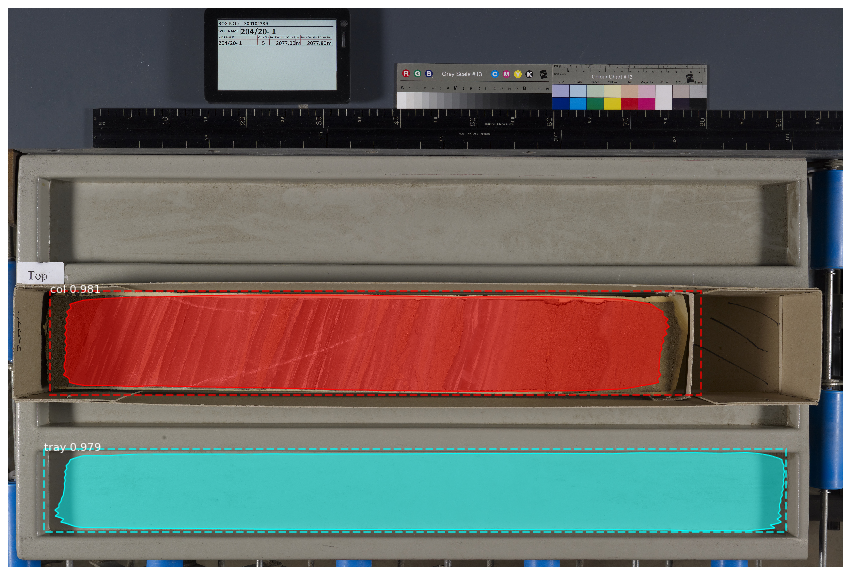

In [15]:
training_img = dataset.load_image(1)

preds = model.detect([training_img], verbose=0)[0]

display_instances(training_img, preds['rois'], preds['masks'], preds['class_ids'],
                 dataset.class_names, preds['scores'], figsize=(15,15))

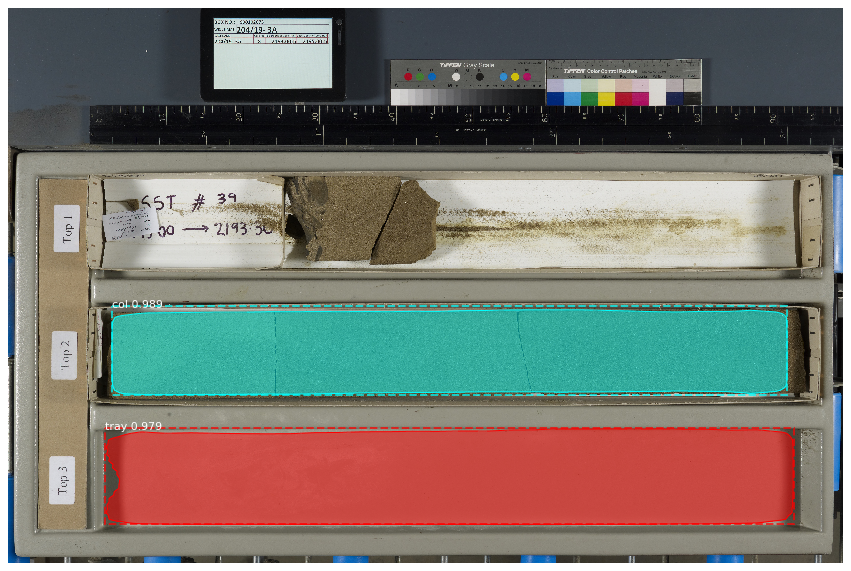

In [9]:
test_img = test_dataset.load_image(1)

preds = model.detect([test_img], verbose=0)[0]

display_instances(test_img, preds['rois'], preds['masks'], preds['class_ids'],
                 test_dataset.class_names, preds['scores'], figsize=(15,15))

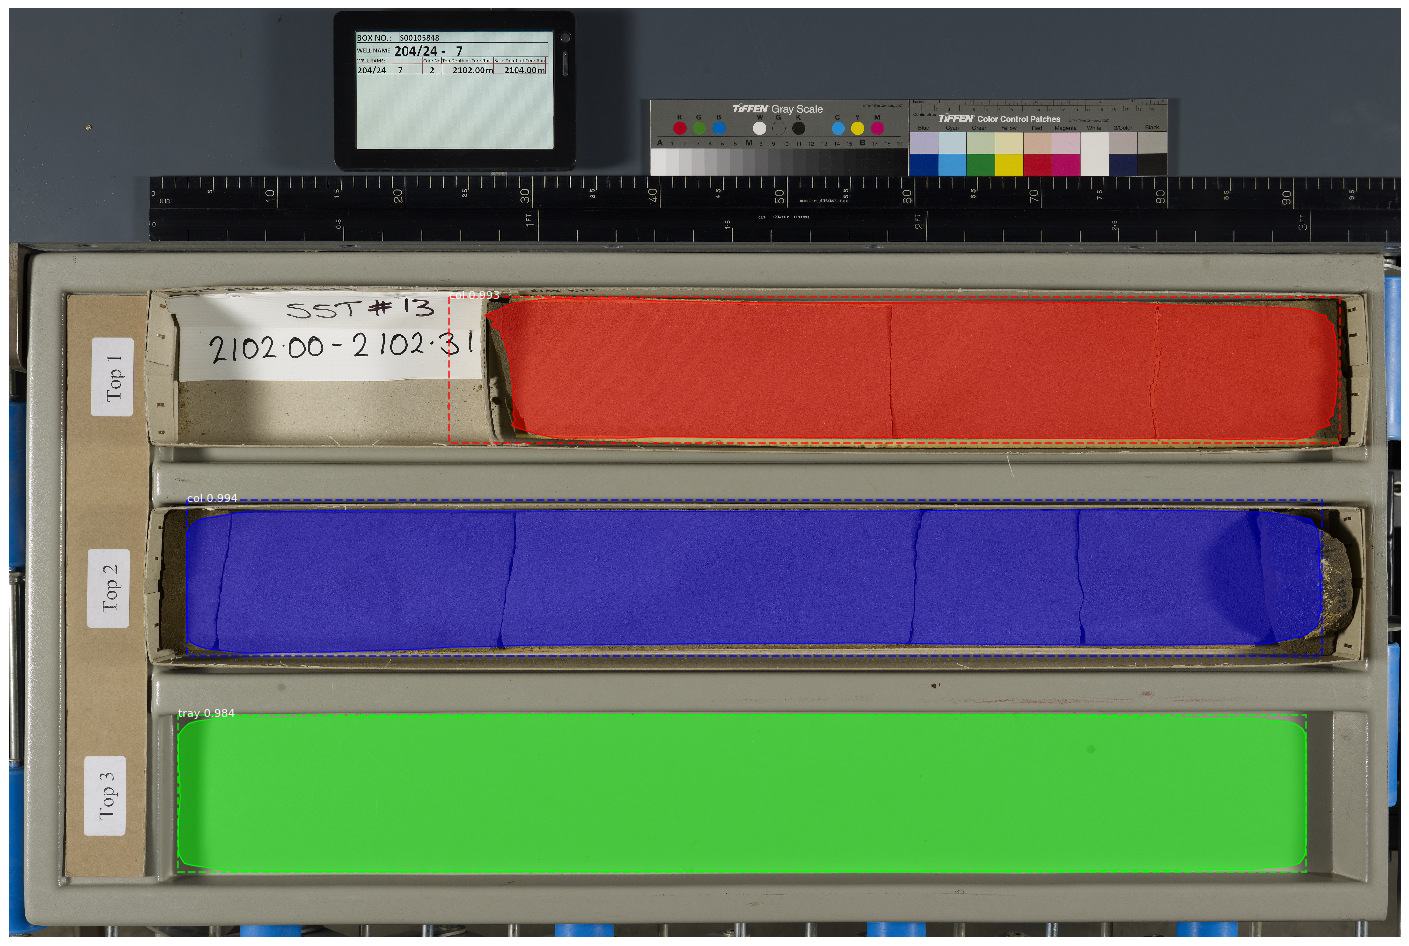

In [14]:
test_img = test_dataset.load_image(2)

preds = model.detect([test_img], verbose=0)[0]

display_instances(test_img, preds['rois'], preds['masks'], preds['class_ids'],
                 test_dataset.class_names, preds['scores'], figsize=(25,25))

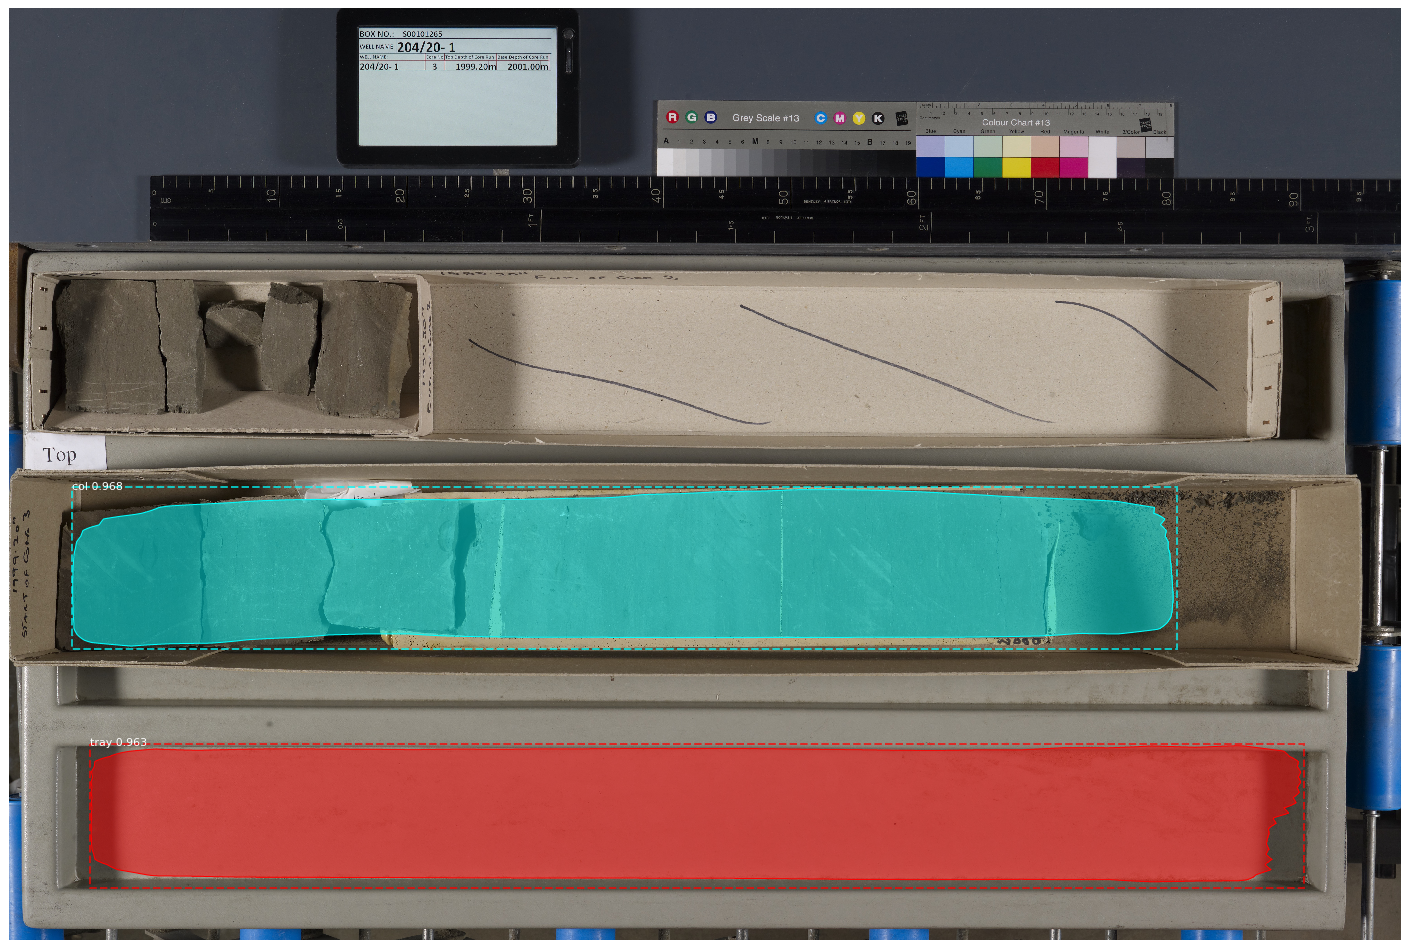

In [19]:
test_img = test_dataset.load_image(0)

preds = model.detect([test_img], verbose=0)[0]

display_instances(test_img, preds['rois'], preds['masks'], preds['class_ids'],
                 test_dataset.class_names, preds['scores'], figsize=(25,25))